# Load libraries

In [27]:
import os
import numpy as np
import torch
import dill as pickle
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets, transforms, models
import pathlib
import matplotlib.pyplot as plt

# Checking for device 

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Data loading

In [29]:
data_transformer = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [30]:
train_path='./seg_train/seg_train'
test_path='./seg_test/seg_test'

train_loader= DataLoader(datasets.ImageFolder(train_path,transform=data_transformer), batch_size=64, shuffle=True)
test_loader= DataLoader(datasets.ImageFolder(test_path,transform=data_transformer), batch_size=32, shuffle=True)

In [31]:
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# CNN Network

In [32]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ConvNet, self).__init__()

        # Output size after convolution filter
        # ((w - f + 2P) / s) + 1
        
        # Inpit shape = (256, 3, 150, 150)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        # Shape (256, 12, 150, 150)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        # Shape (256, 12, 150, 150)
        self.relu1 = nn.ReLU()
        # Shape (256, 12, 150, 150)

        # Reudce the image size by factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Shape (256, 12, 75, 75)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        # Shape (256, 20, 75, 75)
        self.relu2 = nn.ReLU()
        # Shape (256, 20, 75, 75)

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Shape (256, 32, 75, 75)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        # Shape (256, 32, 75, 75)
        self.relu3 = nn.ReLU()
        # Shape (256, 32, 75, 75)

        self.fc = nn.Linear(in_features=75 * 75 * 32, out_features=num_classes)

    # Feed forward function 
    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
              
        output = self.pool(output)
              
        output = self.conv2(output)
        output = self.relu2(output)
              
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
                
        # Above output will be in matrix form, with shape (256,32,75,75)
            
        output = output.view(-1, 32 * 75 * 75)
              
        output = self.fc(output)
            
        return output

In [33]:
model = ConvNet(num_classes=6).to(device)

# Model training and saving best model

In [34]:
optimizer = Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)
loss_function = nn.CrossEntropyLoss()

In [35]:
num_epochs = 10

In [36]:
# Calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

print(train_count,test_count)

14034 3000


In [37]:
train_acc_history = []
test_acc_history = []

best_accuracy = 0.0

for epoch in range(num_epochs):
    
    # Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss += loss.cpu().data * images.size(0)
        _,prediction = torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy / train_count
    train_loss=train_loss / train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = model(images)
        _,prediction = torch.max(outputs.data,1)
        test_accuracy += int(torch.sum(prediction == labels.data))
    
    test_accuracy = test_accuracy / test_count
    
    
    print(f'Epoch: {str(epoch)} Train Loss: {str(train_loss)} Train Accuracy: {str(train_accuracy)} Test Accuracy: {str(test_accuracy)}')
    
    #Save the best model
    if test_accuracy > best_accuracy:
        with open ('best_model.sav', 'wb') as f:
            pickle.dump(model, f)
        best_accuracy = test_accuracy
        
    # Append train and test accuracies to their respective lists
    train_acc_history.append(train_accuracy)
    test_acc_history.append(test_accuracy)


Epoch: 0 Train Loss: tensor(6.1460) Train Accuracy: 0.5846515604959385 Test Accuracy: 0.6033333333333334
Epoch: 1 Train Loss: tensor(2.5322) Train Accuracy: 0.701866894684338 Test Accuracy: 0.6723333333333333
Epoch: 2 Train Loss: tensor(1.3834) Train Accuracy: 0.7662106313239276 Test Accuracy: 0.6946666666666667
Epoch: 3 Train Loss: tensor(0.4887) Train Accuracy: 0.854424967935015 Test Accuracy: 0.7343333333333333
Epoch: 4 Train Loss: tensor(0.3771) Train Accuracy: 0.8844947983468718 Test Accuracy: 0.7493333333333333
Epoch: 5 Train Loss: tensor(0.2526) Train Accuracy: 0.9235428245689041 Test Accuracy: 0.731
Epoch: 6 Train Loss: tensor(0.1733) Train Accuracy: 0.9455607809605244 Test Accuracy: 0.758
Epoch: 7 Train Loss: tensor(0.1485) Train Accuracy: 0.9546102322930027 Test Accuracy: 0.7603333333333333
Epoch: 8 Train Loss: tensor(0.1146) Train Accuracy: 0.9681487815305686 Test Accuracy: 0.745
Epoch: 9 Train Loss: tensor(0.1199) Train Accuracy: 0.9620208066125124 Test Accuracy: 0.72133333

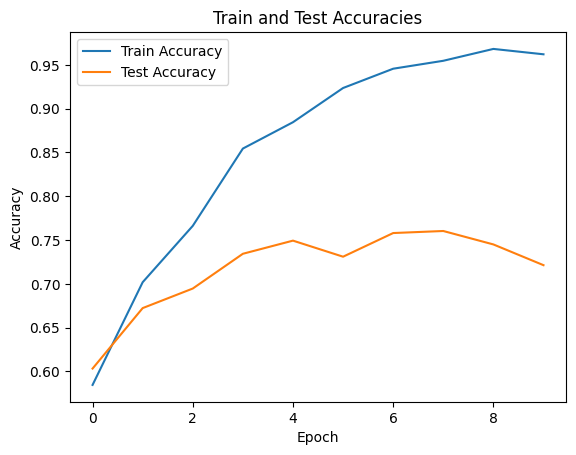

In [38]:
# Plotting train and test accuracies
plt.plot(range(num_epochs), train_acc_history, label='Train Accuracy')
plt.plot(range(num_epochs), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies')
plt.legend()
plt.show()